In [1]:
#Python
import numpy as np
import ConfigParser
from matplotlib import pyplot as plt
#Keras
from keras.models import model_from_json
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Convolution2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, LSTM, merge, Lambda, UpSampling2D, Deconvolution2D, Cropping2D
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plot
from keras.optimizers import SGD
from keras.optimizers import Adagrad
#scikit learn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from skimage.transform import resize

import sys
sys.path.insert(0, './lib/')
# help_functions.py
from help_functions import *
# extract_patches.py
from extract_patches import extract_ordered
from extract_patches import extract_ordered_overlap
from extract_patches import recompone
from extract_patches import recompone_overlap
from extract_patches import paint_border
from extract_patches import kill_border
from extract_patches import pred_only_FOV
from extract_patches import get_data_testing
from extract_patches import get_data_testing_overlap
# pre_processing.py
from pre_processing import my_PreProc




from PIL import Image

Using TensorFlow backend.


In [2]:
path_experiment = "DISC_segmentation/"
name_experiment = "Segmenter3"

input_path = path_experiment+ name_experiment + '/' +  name_experiment 
output_path = path_experiment+  name_experiment 

config = ConfigParser.RawConfigParser()
config.read(path_experiment + name_experiment + '/' + 'configuration.txt')


best_last = "best"
Imgs_to_test = 15
#patch_height = int(config.get('training settings','patch_height'))
#patch_width = int(config.get('training settings','patch_width'))
patch_height = 480
patch_width = 480
average_mode = False
is_extract = False
trim = True
overlap = False

full_img_height = 480
full_img_width = 480

In [3]:
#test_imgs_original = load_hdf5("DISC/raw_test.hdf5")
#test_masks = load_hdf5("DISC/mask_test.hdf5")

test_imgs_original = load_hdf5("DISC/raw_train.hdf5")
test_masks = load_hdf5("DISC/mask_train.hdf5")

In [25]:
# STARE
trim = False
STARE = load_hdf5("STARE_dataset/STARE_dataset_imgs_train.hdf5")
mask = load_hdf5("STARE_dataset/STARE_dataset_groundTruth_train.hdf5")

test_imgs_original = np.zeros((STARE.shape[0],3,480,480))
test_masks = np.zeros((STARE.shape[0],1,480,480))
for i in range(STARE.shape[0]):
    t = resize(STARE[i],(3,480,480))
    m = resize(mask[i],(1,480,480))
    test_imgs_original[i] = t
    test_masks[i] = m    

/home/sh402/retina-unet/rop_env_cpu/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [18]:
# DRIVE
trim = False
test_imgs_original = load_hdf5(("DRIVE_datasets_training_testing/DRIVE_dataset_imgs_train.hdf5"))
test_masks = load_hdf5("DRIVE_datasets_training_testing/DRIVE_dataset_groundTruth_train.hdf5")
test_imgs_original = test_imgs_original[:,:,52:532,42:522]
test_masks = test_masks[:,:,52:532,42:522]


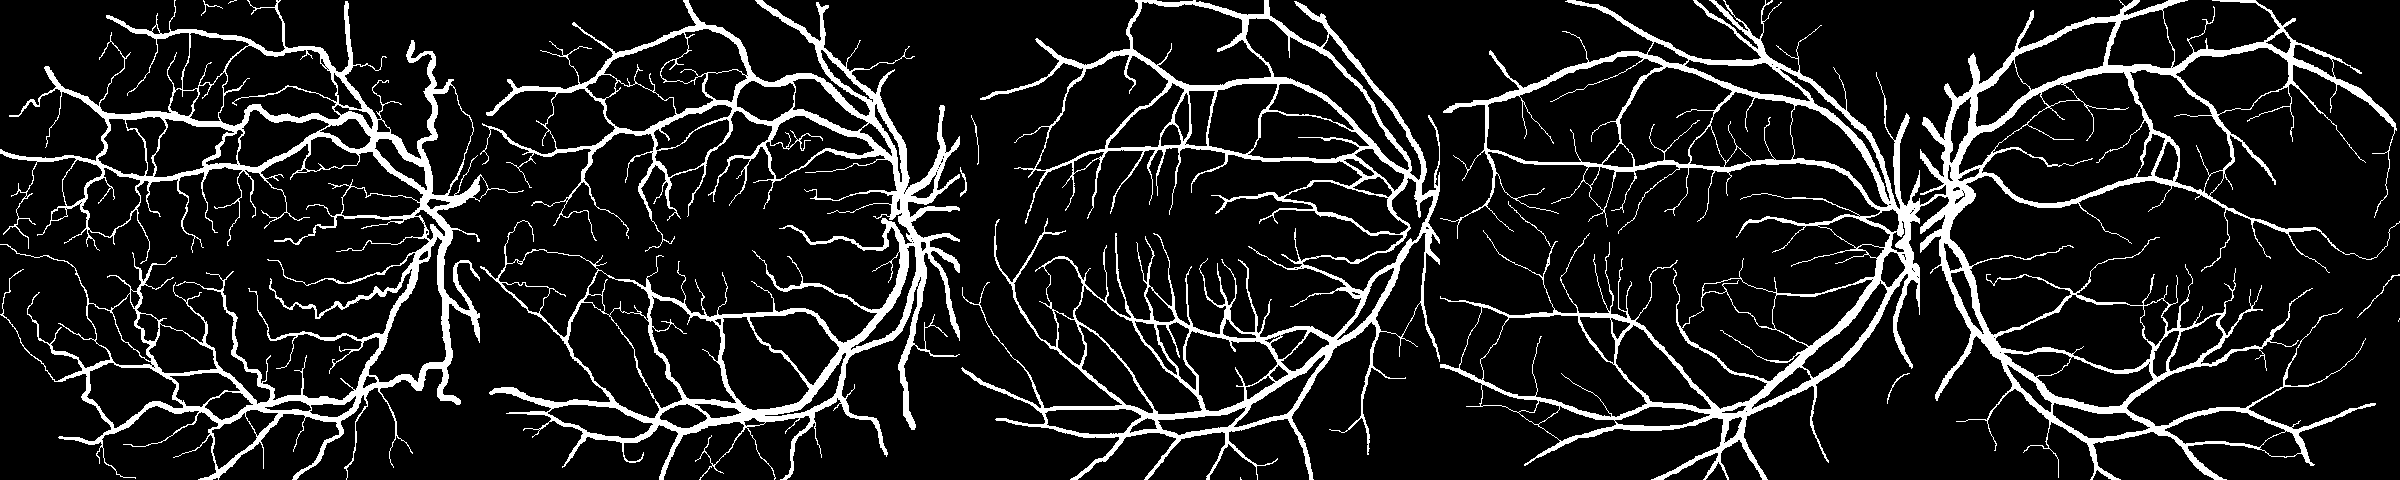

In [4]:
visualize(group_images(test_masks[0:5,:,:,:],5),'gtruth')#.show()

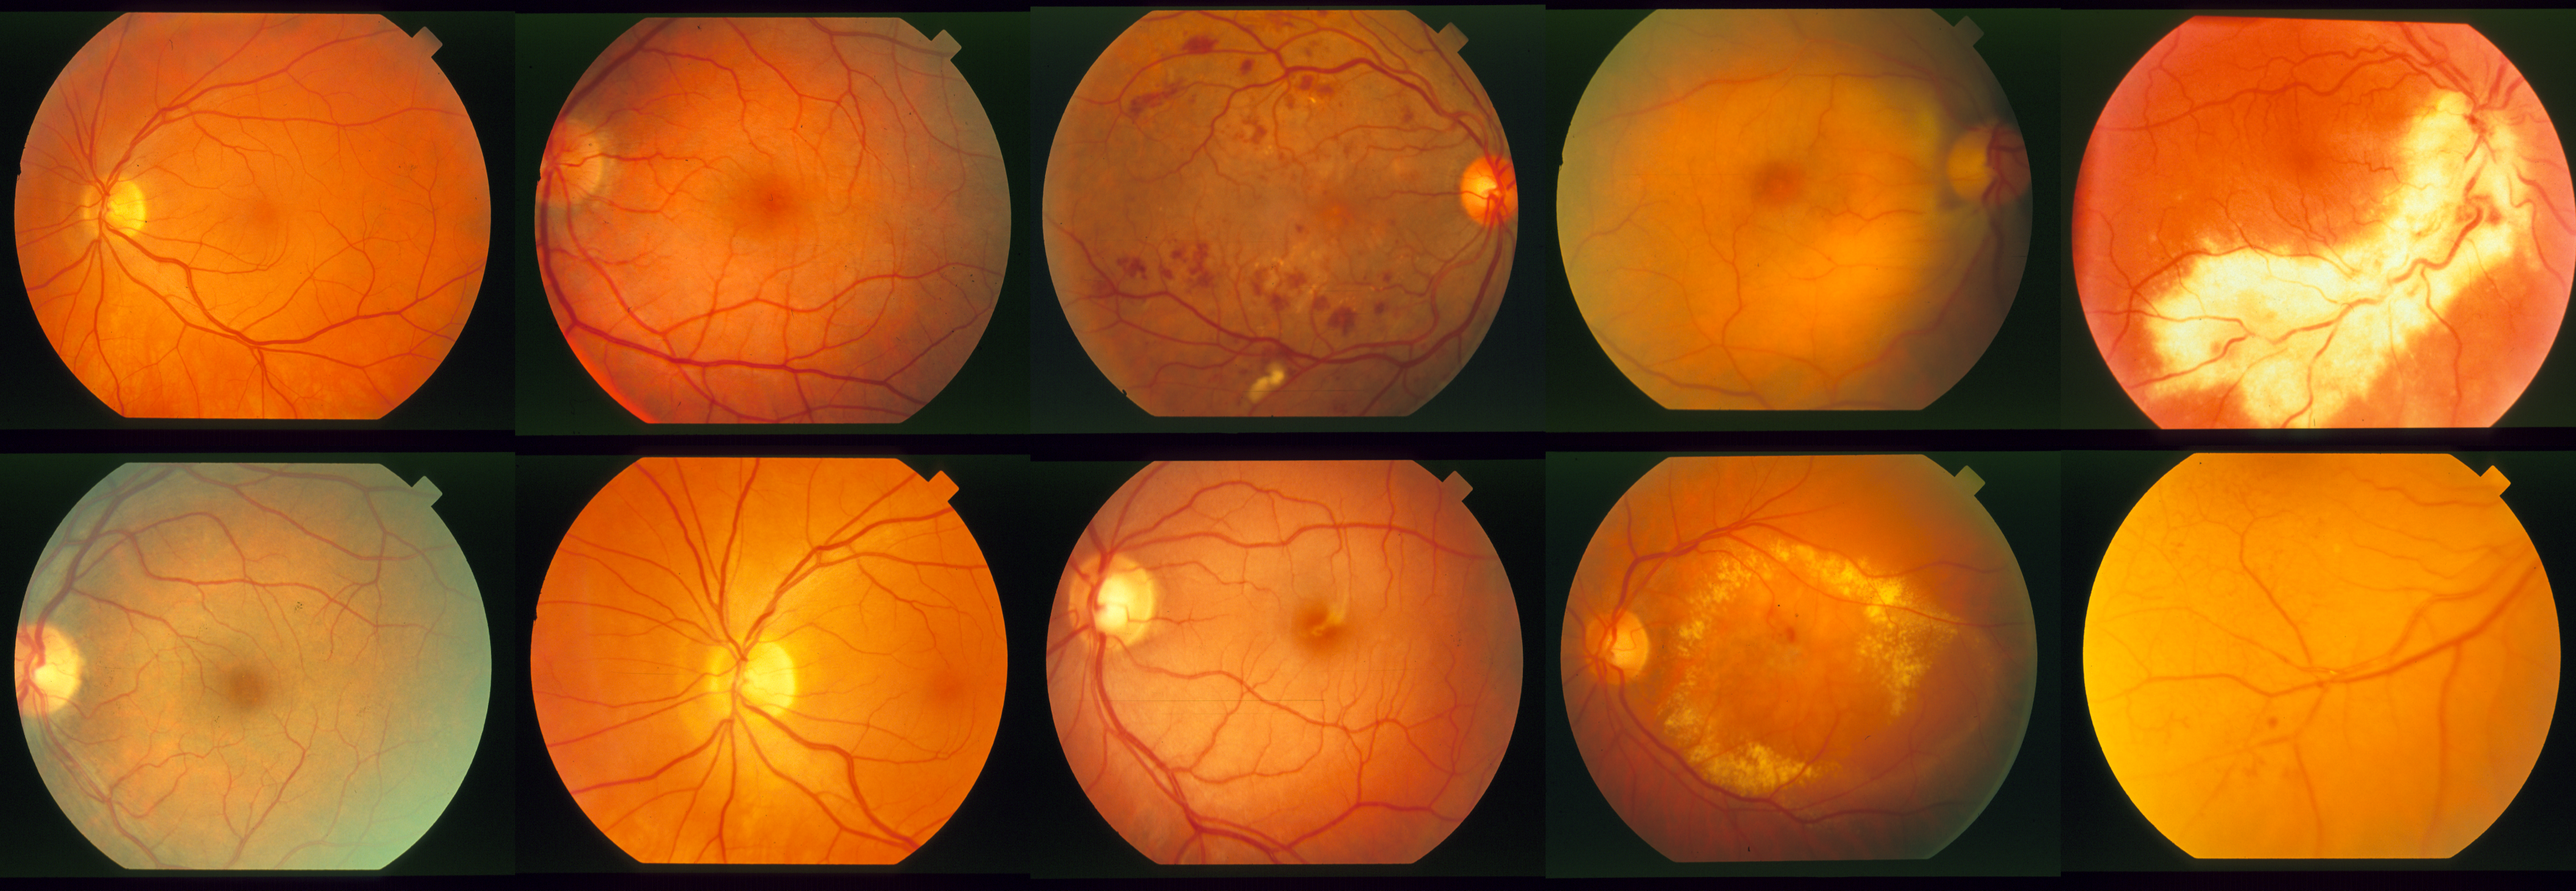

In [25]:
#test_imgs_original.shape
visualize(group_images(STARE[0:10,:,:,:],5),'gtruth')#.show()

In [4]:
test_imgs = my_PreProc(test_imgs_original)
#test_masks = test_masks/255.

    #extend both images and masks so they can be divided exactly by the patches dimensions
test_imgs = test_imgs[0:Imgs_to_test,:,:,:]
test_masks = test_masks[0:Imgs_to_test,:,:,:]

if trim == True:
    test_imgs = test_imgs[:,:,:,80:560]
    test_masks = test_masks[:,:,:,80:560]

if is_extract == True:
    test_imgs = paint_border(test_imgs,patch_height,patch_width)
    test_masks = paint_border(test_masks,patch_height,patch_width)
    
    if overlap == True:
        patches_imgs_test = extract_ordered_overlap(test_imgs, patch_height, patch_width,stride_h,stride_w)
        patches_masks_test = extract_ordered_overlap(test_masks, patch_height, patch_width,stride_h,stride_w)
    else:
        patches_imgs_test = extract_ordered(test_imgs,patch_height,patch_width)
        patches_masks_test = extract_ordered(test_masks,patch_height,patch_width)
else:
    patches_imgs_test = test_imgs
    patches_masks_test = test_masks
    


In [27]:
patches_imgs_test.shape

(15, 1, 480, 480)

In [5]:
#model = model_from_json(open(path_experiment+name_experiment +'_architecture.json').read())
model = model_from_json(open(path_experiment+ name_experiment + '/' +  name_experiment + '_architecture.json').read())
model.load_weights(path_experiment + name_experiment + '/' +  name_experiment +  '_'+best_last+'_weights.h5')
#Calculate the predictions
predictions = model.predict(patches_imgs_test, batch_size=32, verbose=2)
print "predicted images size :"
print predictions.shape

#===== Convert the prediction arrays in corresponding images
#pred_patches = pred_to_imgs(predictions, patch_height, patch_width, "original")
pred_patches = predictions

predicted images size :
(15, 1, 480, 480)


In [6]:
pred_patches.shape

(15, 1, 480, 480)

In [30]:
np.max(pred_patches)

1.0

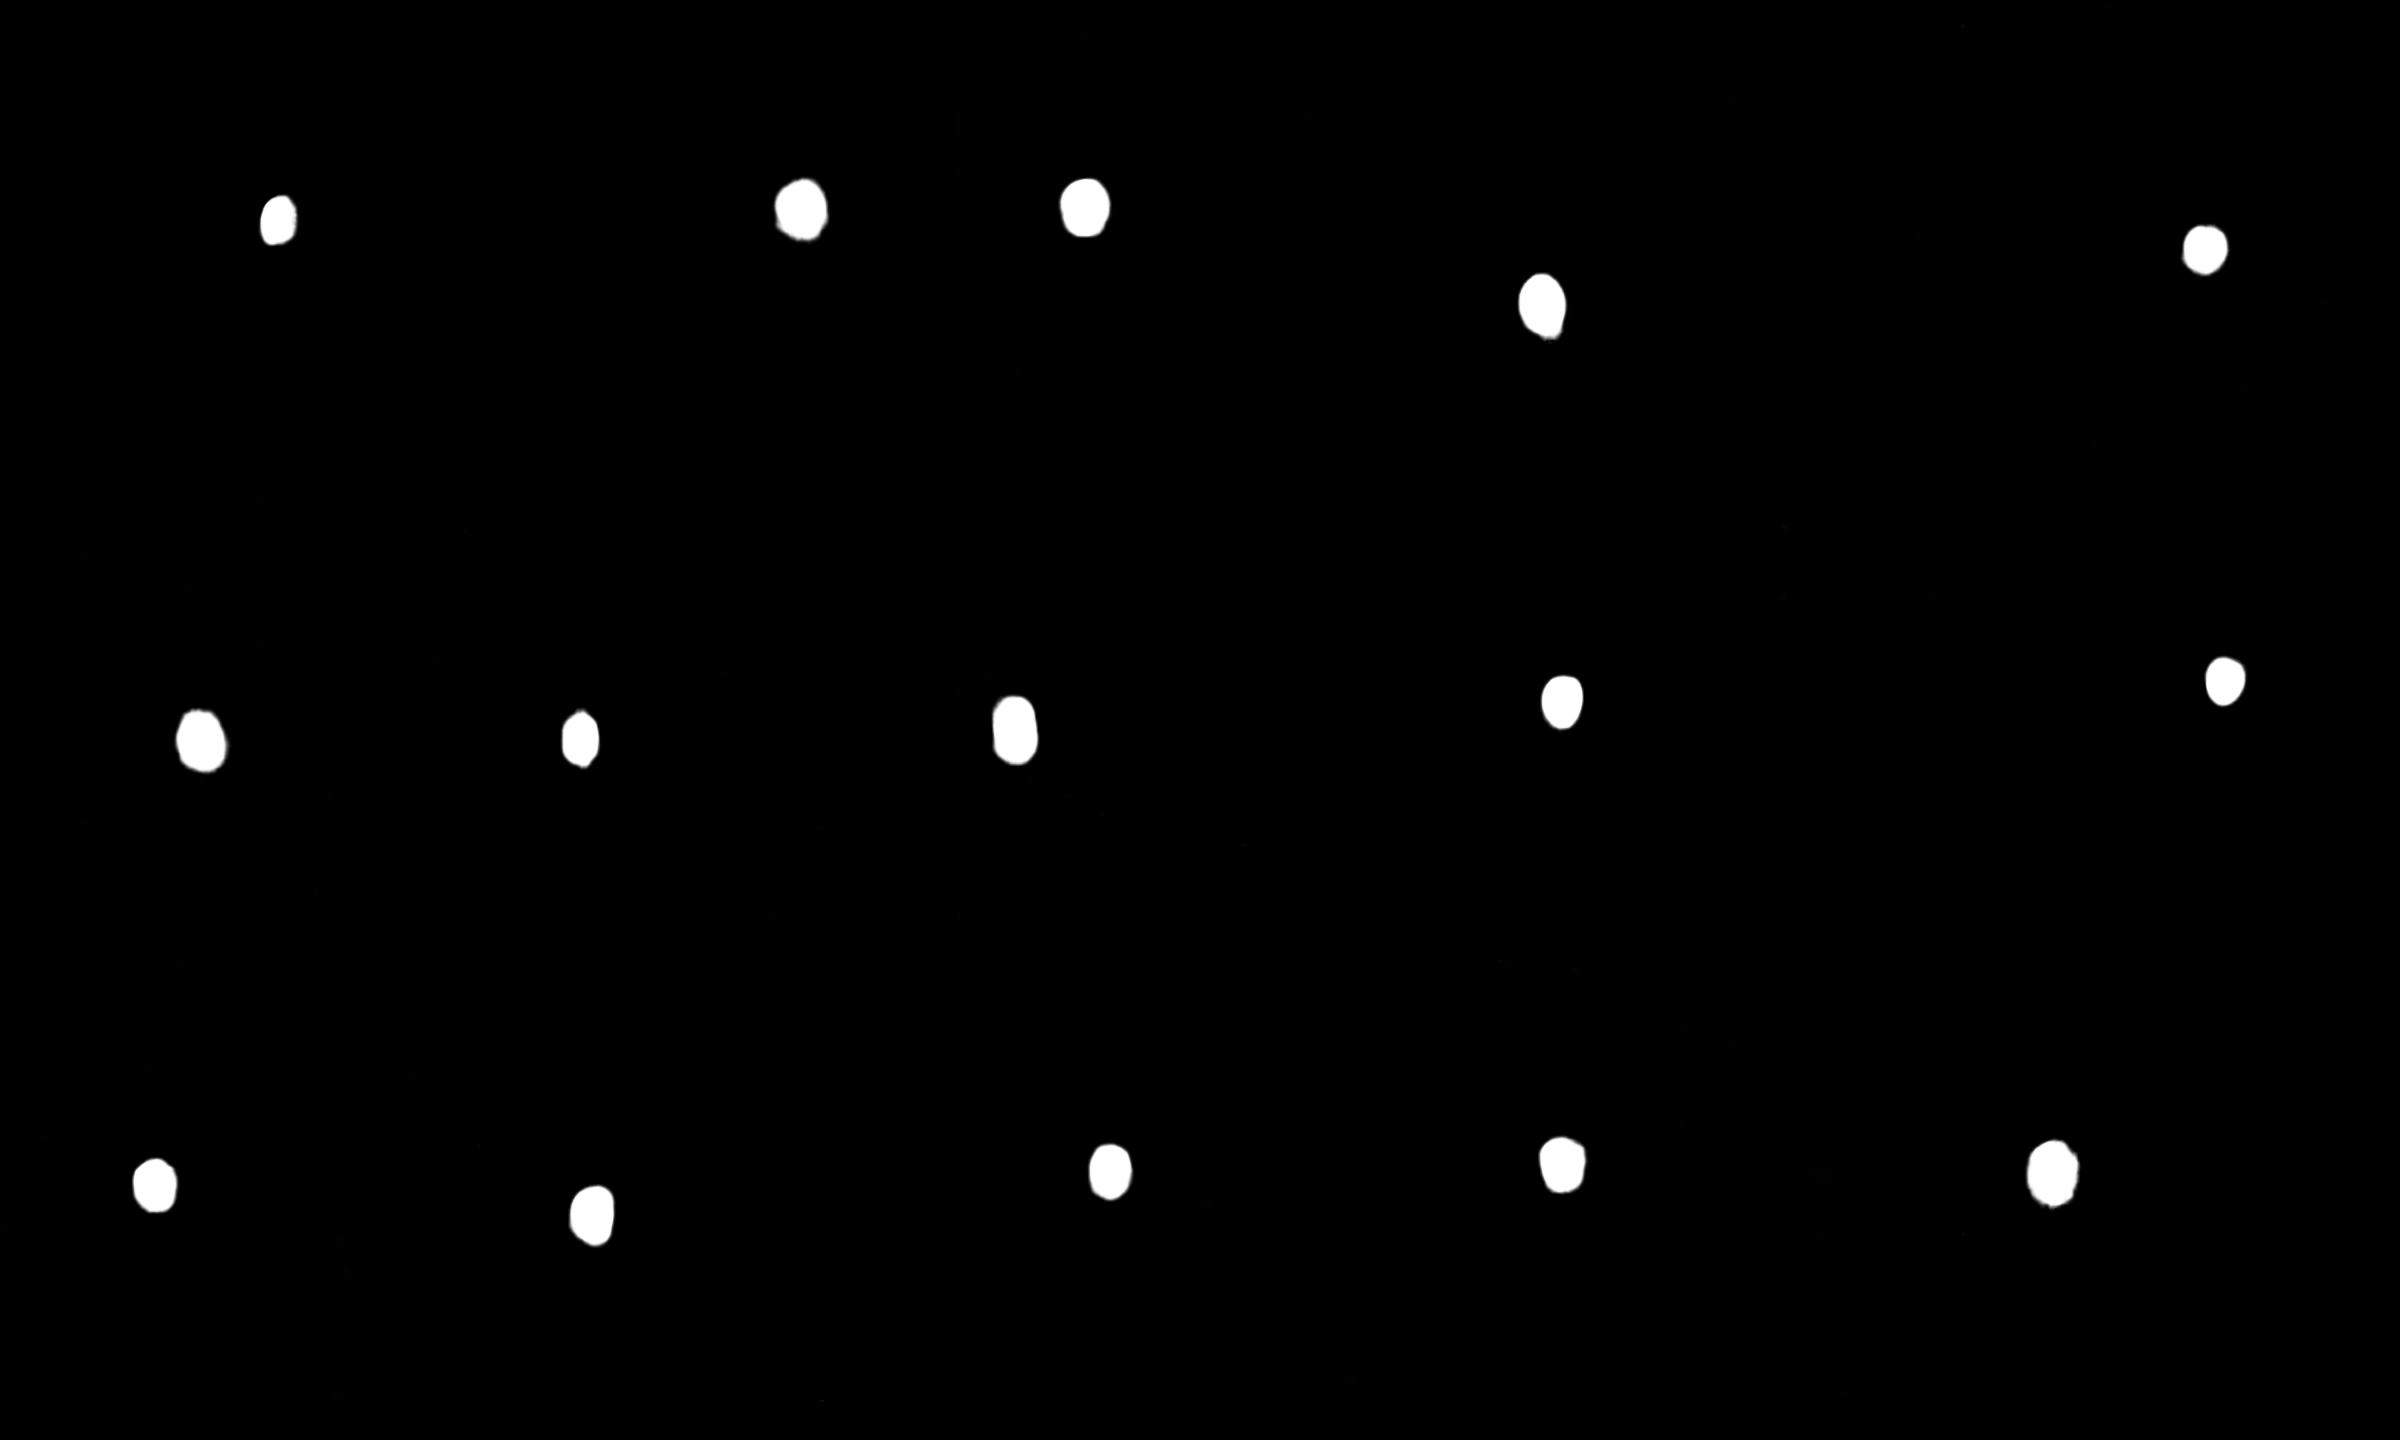

In [7]:
visualize(group_images(pred_patches[:,:,:,:],5),path_experiment+"all_originals")

# Processing Predicting Patches

In [8]:

pred_imgs = None
orig_imgs = None
gtruth_masks = None

if average_mode == True:
    pred_imgs = recompone_overlap(pred_patches, new_height, new_width, stride_height, stride_width)# predictions
    orig_imgs = my_PreProc(test_imgs_orig[0:pred_imgs.shape[0],:,:,:])    #originals
    gtruth_masks = masks_test  #ground truth masks
else:
    pred_imgs = recompone(pred_patches,10,10)       # predictions
    orig_imgs = recompone(patches_imgs_test,10,10)  # originals
    gtruth_masks = recompone(patches_masks_test,10,10)  #masks
    
# apply the DRIVE masks on the repdictions #set everything outside the FOV to zero!!
#kill_border(pred_imgs, test_border_masks)  #DRIVE MASK  #only for visualization
## back to original dimensions
orig_imgs = orig_imgs[:,:,0:full_img_height,0:full_img_width]
pred_imgs = pred_imgs[:,:,0:full_img_height,0:full_img_width]
gtruth_masks = gtruth_masks[:,:,0:full_img_height,0:full_img_width]
print "Orig imgs shape: " +str(orig_imgs.shape)
print "pred imgs shape: " +str(pred_imgs.shape)
print "Gtruth imgs shape: " +str(gtruth_masks.shape)

AssertionError: 

In [180]:
pred_imgs = rank_pred_imgs
orig_imgs = rank_orig_imgs
gtruth_masks = rank_gtruth_masks
pred_imgs = np.where(pred_imgs > threshold, 1, 0)

In [167]:
pred_imgs = temp

In [168]:
temp = pred_imgs
t = np.where(pred_imgs > 0.5, 1, 0)
pred_imgs = t

In [93]:
visualize(t.reshape(480,480,1),"test")

ValueError: cannot reshape array of size 3456000 into shape (480,480,1)

In [32]:
orig_imgs = test_imgs
pred_imgs = predictions

N_visual = 5
visualize(group_images(orig_imgs,N_visual),output_path + "all_originals")#.show()
visualize(group_images(pred_imgs,N_visual),output_path + "all_predictions")#.show()
#visualize(group_images(gtruth_masks,N_visual),output_path+ "all_groundTruths")#.show()
#visualize results comparing mask and prediction:
#assert (orig_imgs.shape[0]==pred_imgs.shape[0] and orig_imgs.shape[0]==gtruth_masks.shape[0])
N_predicted = orig_imgs.shape[0]
group = N_visual
assert (N_predicted%group==0)
for i in range(int(N_predicted/group)):
    orig_stripe = group_images(orig_imgs[i*group:(i*group)+group,:,:,:],group)
    #masks_stripe = group_images(gtruth_masks[i*group:(i*group)+group,:,:,:],group)
    pred_stripe = group_images(pred_imgs[i*group:(i*group)+group,:,:,:],group)
    #total_img = np.concatenate((orig_stripe,masks_stripe,pred_stripe),axis=0)
    total_img = np.concatenate((orig_stripe,pred_stripe),axis=0)
    visualize(total_img,output_path + "_Original_GroundTruth_Prediction"+str(i))#.show()

In [19]:
test_imgs.shape

(15, 1, 480, 480)

In [21]:
y_true = np.asarray(gtruth_masks.reshape(-1))
y_scores = np.asarray(pred_imgs.reshape(-1))

In [22]:
len(y_true)

3456000

In [9]:
pred_imgs = predictions     # predictions
orig_imgs = patches_imgs_test
gtruth_masks = patches_masks_test

mean_dice = []
mean_iou = []
all_dice = dict() 
all_iou = dict()
for threshold in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    t = np.where(pred_imgs > threshold, 1, 0)
    
    iou = []
    dice = []

    for i in range(len(pred_imgs)):
        intersect = 0
        union = 0
        true = np.asarray(gtruth_masks[i].reshape(-1))
        scores = np.asarray(t[i].reshape(-1))
        for j in range(len(true)):
            if true[j] == 1 and scores[j] == 1:
                intersect += 1
            if true[j] == 1 or scores[j] == 1:
                union += 1
        
    

        iou.append(intersect/float(union))
        dice.append(intersect*2/float(np.sum(true == 1) + np.sum(scores == 1)))
        
        
    all_iou[threshold] = iou
    all_dice[threshold] = dice
    mean_iou.append(np.mean(iou))
    mean_dice.append(np.mean(dice))
    print("threshold = ", threshold)
    print("mean iou = ", np.mean(iou))

    print("mean dice = ", np.mean(dice))

('threshold = ', 0.1)
('mean iou = ', 0.8764764254514648)
('mean dice = ', 0.9338528491976823)
('threshold = ', 0.2)
('mean iou = ', 0.9049244478990357)
('mean dice = ', 0.9498629317245123)
('threshold = ', 0.3)
('mean iou = ', 0.9257123357707873)
('mean dice = ', 0.9612645992068808)
('threshold = ', 0.4)
('mean iou = ', 0.9340336627648633)
('mean dice = ', 0.9657838853509061)
('threshold = ', 0.5)
('mean iou = ', 0.9356511426763077)
('mean dice = ', 0.966670066559428)
('threshold = ', 0.6)
('mean iou = ', 0.9332109326281288)
('mean dice = ', 0.9653706815245664)
('threshold = ', 0.7)
('mean iou = ', 0.9255736760945904)
('mean dice = ', 0.9612512540811787)
('threshold = ', 0.8)
('mean iou = ', 0.9104862479786378)
('mean dice = ', 0.9530326751324278)
('threshold = ', 0.9)
('mean iou = ', 0.8850893911264145)
('mean dice = ', 0.938902340605197)


In [10]:
## BEST RESULTS PRESERVED
pred_imgs = predictions     # predictions
orig_imgs = patches_imgs_test
gtruth_masks = patches_masks_test

mean_dice = []
mean_iou = []
all_dice = dict() 
all_iou = dict()
for threshold in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    t = np.where(pred_imgs > threshold, 1, 0)
    
    iou = []
    dice = []

    for i in range(len(pred_imgs)):
        intersect = 0
        union = 0
        true = np.asarray(gtruth_masks[i].reshape(-1))
        scores = np.asarray(t[i].reshape(-1))
        for j in range(len(true)):
            if true[j] == 1 and scores[j] == 1:
                intersect += 1
            if true[j] == 1 or scores[j] == 1:
                union += 1
        
    

        iou.append(intersect/float(union))
        dice.append(intersect*2/float(np.sum(true == 1) + np.sum(scores == 1)))
        
        
    all_iou[threshold] = iou
    all_dice[threshold] = dice
    mean_iou.append(np.mean(iou))
    mean_dice.append(np.mean(dice))
    print("threshold = ", threshold)
    print("mean iou = ", np.mean(iou))

    print("mean dice = ", np.mean(dice))

('threshold = ', 0.1)
('mean iou = ', 0.8764764254514648)
('mean dice = ', 0.9338528491976823)
('threshold = ', 0.2)
('mean iou = ', 0.9049244478990357)
('mean dice = ', 0.9498629317245123)
('threshold = ', 0.3)
('mean iou = ', 0.9257123357707873)
('mean dice = ', 0.9612645992068808)
('threshold = ', 0.4)
('mean iou = ', 0.9340336627648633)
('mean dice = ', 0.9657838853509061)
('threshold = ', 0.5)
('mean iou = ', 0.9356511426763077)
('mean dice = ', 0.966670066559428)
('threshold = ', 0.6)
('mean iou = ', 0.9332109326281288)
('mean dice = ', 0.9653706815245664)
('threshold = ', 0.7)
('mean iou = ', 0.9255736760945904)
('mean dice = ', 0.9612512540811787)
('threshold = ', 0.8)
('mean iou = ', 0.9104862479786378)
('mean dice = ', 0.9530326751324278)
('threshold = ', 0.9)
('mean iou = ', 0.8850893911264145)
('mean dice = ', 0.938902340605197)


In [11]:
import pandas as pd
iou_df = pd.DataFrame.from_dict(all_iou)
iou_df.to_csv(output_path + "all_iou.csv")

dice_df = pd.DataFrame.from_dict(all_dice)
dice_df.to_csv(output_path + "all_dice.csv")

In [14]:
threshold = 0.5
t = np.where(pred_imgs > threshold, 1, 0)
iou = []
dice = []
for i in range(len(pred_imgs)):
    intersect = 0
    union = 0
    true = np.asarray(gtruth_masks[i].reshape(-1))
    scores = np.asarray(t[i].reshape(-1))
    for j in range(len(true)):
        if true[j] == 1 and scores[j] == 1:
            intersect += 1
        if true[j] == 1 or scores[j] == 1:
            union += 1
        
    iou.append(intersect/float(union))
    dice.append(intersect*2/float(np.sum(true == 1) + np.sum(scores == 1)))


In [15]:
dice = np.array(dice)
dice[np.argsort(ranks)]

array([0.98341359, 0.96303258, 0.97219809, 0.98019802, 0.97952817,
       0.96597463, 0.95079951, 0.96839161, 0.95009397, 0.96121884,
       0.9686747 , 0.96650192, 0.96914701, 0.96279454, 0.95808383])

In [16]:
# Output Rank Image Results
iou = np.array(iou)
order = (-iou).argsort()
ranks = order.argsort()
ranks

rank_pred_imgs = np.zeros_like(pred_imgs)
rank_orig_imgs = np.zeros_like(orig_imgs)
rank_gtruth_masks = np.zeros_like(gtruth_masks)
for i,j in enumerate(ranks):
    rank_pred_imgs[j,:,:,:] = pred_imgs[i,:,:,:]
    rank_orig_imgs[j,:,:,:] = orig_imgs[i,:,:,:]
    rank_gtruth_masks[j,:,:,:] = gtruth_masks[i,:,:,:]
    
rank_pred_imgs = np.where(rank_pred_imgs > threshold, 1, 0)

N_visual = 5
N_predicted = orig_imgs.shape[0]
group = N_visual
assert (N_predicted%group==0)
for i in range(int(N_predicted/group)):
    orig_stripe = group_images(rank_orig_imgs[i*group:(i*group)+group,:,:,:],group)
    masks_stripe = group_images(rank_gtruth_masks[i*group:(i*group)+group,:,:,:],group)
    pred_stripe = group_images(rank_pred_imgs[i*group:(i*group)+group,:,:,:],group)
    total_img = np.concatenate((orig_stripe,masks_stripe,pred_stripe),axis=0)
    #total_img = np.concatenate((orig_stripe,pred_stripe),axis=0)
    visualize(total_img,output_path + "Ranked_Original_GroundTruth_Prediction"+str(i))#.show()

In [37]:
output_path

'DISC_segmentation/Segmenter4/Ranked_'

In [28]:
iou = np.array(iou)
order = (-iou).argsort()
ranks = order.argsort()
ranks

rank_pred_imgs = np.zeros_like(pred_imgs)
rank_orig_imgs = np.zeros_like(orig_imgs)
rank_gtruth_masks = np.zeros_like(gtruth_masks)
for i,j in enumerate(ranks):
    rank_pred_imgs[j,:,:,:] = pred_imgs[i,:,:,:]
    rank_orig_imgs[j,:,:,:] = orig_imgs[i,:,:,:]
    rank_gtruth_masks[j,:,:,:] = gtruth_masks[i,:,:,:]
    

In [27]:
iou = np.array(iou)
order = (-iou).argsort()
ranks = order.argsort()
ranks

array([10, 12,  5,  9,  6, 11,  1,  4,  0,  2,  7,  8, 13, 14,  3])

In [29]:
iou

array([0.85349941, 0.83436533, 0.88395475, 0.87041467, 0.87761675,
       0.8420638 , 0.91331658, 0.89371606, 0.91657754, 0.9053103 ,
       0.8764881 , 0.87522282, 0.81562348, 0.8002456 , 0.90335437])

In [166]:
pred_imgs = rank_pred_imgs
orig_imgs = rank_orig_imgs
gtruth_masks = rank_gtruth_masks
pred_imgs = np.where(pred_imgs > threshold, 1, 0)

In [129]:
gtruth_masks.shape

(1, 480, 480)

In [101]:
sorted(iou,reverse=True)

[0.9287068638604474,
 0.9278409090909091,
 0.915891472868217,
 0.9046134663341646,
 0.9031049250535332,
 0.9016979445933869,
 0.8954314720812183,
 0.8933588761174968,
 0.8805394990366089,
 0.8760757314974182,
 0.8657195233730522,
 0.8457672980286045,
 0.8284438775510204,
 0.8220640569395018,
 0.6123015873015873]

# Evaluation



========  Evaluate the results =======================
Calculating results only inside the FOV:
y scores pixels: 3456000 (radius 270: 270*270*3.14==228906), including background around retina: 3456000 (584*565==329960)
y true pixels: 3456000 (radius 270: 270*270*3.14==228906), including background around retina: 3456000 (584*565==329960)

Area under the ROC curve: 0.9300906183129576

Area under Precision-Recall curve: 0.9210491141769297

Confusion matrix:  Costum threshold (for positive) of 0.5
[[3424423     531]
 [   4336   26710]]
Global Accuracy: 0.998591724537
Specificity: 0.999844961421
Sensitivity: 0.860336275205
Precision: 0.98050732352

Jaccard similarity score: 0.998591724537037

F1 score (F-measure): 0.9164993909448077


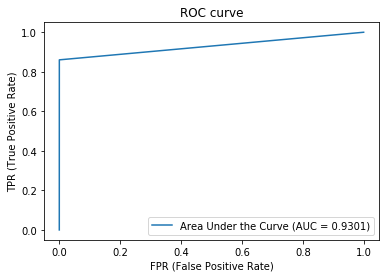

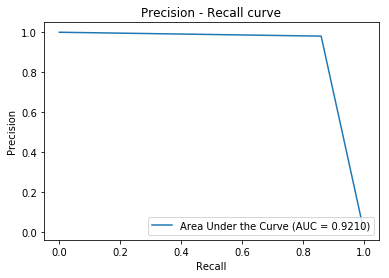

In [107]:
print "\n\n========  Evaluate the results ======================="
#predictions only inside the FOV
#y_scores, y_true = pred_only_FOV(pred_imgs,gtruth_masks, test_border_masks)  #returns data only inside the FOV
print "Calculating results only inside the FOV:"
print "y scores pixels: " +str(y_scores.shape[0]) +" (radius 270: 270*270*3.14==228906), including background around retina: " +str(pred_imgs.shape[0]*pred_imgs.shape[2]*pred_imgs.shape[3]) +" (584*565==329960)"
print "y true pixels: " +str(y_true.shape[0]) +" (radius 270: 270*270*3.14==228906), including background around retina: " +str(gtruth_masks.shape[2]*gtruth_masks.shape[3]*gtruth_masks.shape[0])+" (584*565==329960)"

#Area under the ROC curve
fpr, tpr, thresholds = roc_curve((y_true), y_scores)
AUC_ROC = roc_auc_score(y_true, y_scores)
# test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
print "\nArea under the ROC curve: " +str(AUC_ROC)
roc_curve =plt.figure()
plt.plot(fpr,tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.savefig(path_experiment+"ROC.png")

#Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
precision = np.fliplr([precision])[0]  #so the array is increasing (you won't get negative AUC)
recall = np.fliplr([recall])[0]  #so the array is increasing (you won't get negative AUC)
AUC_prec_rec = np.trapz(precision,recall)
print "\nArea under Precision-Recall curve: " +str(AUC_prec_rec)
prec_rec_curve = plt.figure()
plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower right")
plt.savefig(path_experiment+"Precision_recall.png")

#Confusion matrix
threshold_confusion = 0.5
print "\nConfusion matrix:  Costum threshold (for positive) of " +str(threshold_confusion)
y_pred = np.empty((y_scores.shape[0]))
for i in range(y_scores.shape[0]):
    if y_scores[i]>=threshold_confusion:
        y_pred[i]=1
    else:
        y_pred[i]=0
confusion = confusion_matrix(y_true, y_pred)
print confusion
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print "Global Accuracy: " +str(accuracy)
specificity = 0
if float(confusion[0,0]+confusion[0,1])!=0:
    specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
print "Specificity: " +str(specificity)
sensitivity = 0
if float(confusion[1,1]+confusion[1,0])!=0:
    sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
print "Sensitivity: " +str(sensitivity)
precision = 0
if float(confusion[1,1]+confusion[0,1])!=0:
    precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
print "Precision: " +str(precision)

#Jaccard similarity index
jaccard_index = jaccard_similarity_score(y_true, y_pred, normalize=True)
print "\nJaccard similarity score: " +str(jaccard_index)

#F1 score
F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
print "\nF1 score (F-measure): " +str(F1_score)

#Save the results
file_perf = open(path_experiment+'performances.txt', 'w')
file_perf.write("Area under the ROC curve: "+str(AUC_ROC)
                + "\nArea under Precision-Recall curve: " +str(AUC_prec_rec)
                + "\nJaccard similarity score: " +str(jaccard_index)
                + "\nF1 score (F-measure): " +str(F1_score)
                +"\n\nConfusion matrix:"
                +str(confusion)
                +"\nACCURACY: " +str(accuracy)
                +"\nSENSITIVITY: " +str(sensitivity)
                +"\nSPECIFICITY: " +str(specificity)
                +"\nPRECISION: " +str(precision)
                )
file_perf.close()

In [1]:
import pandas as pd

In [2]:
history = pd.read_csv("DISC_segmentation/TrainableUnetTest/TrainableUnetTest_history.csv")

In [6]:
history

Unnamed: 0       acc  dice_metric      loss  mean_IOU_gpu   val_acc  \
0           0  0.046061     0.126102  2.743091      0.073244  0.252557   

   val_dice_metric  val_loss  val_mean_IOU_gpu  
0         0.024581  3.729929          0.012457

In [17]:
predictions = load_hdf5("DISC_segmentation/TrainableUnetTest/TrainableUnetTest_prediction.h5")
patches_imgs_test = load_hdf5('DISC/raw_test.hdf5')
patches_masks_test = load_hdf5('DISC/mask_test.hdf5')
patches_imgs_test = patches_imgs_test[:,:,:,80:560]
patches_masks_test = patches_masks_test[:,:,:,80:560]


In [16]:
patches_imgs_test.shape

(19, 3, 480, 640)

In [18]:
pred_imgs = predictions     # predictions
orig_imgs = patches_imgs_test
gtruth_masks = patches_masks_test

mean_dice = []
mean_iou = []
all_dice = dict() 
all_iou = dict()
for threshold in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    t = np.where(pred_imgs > threshold, 1, 0)
    
    iou = []
    dice = []

    for i in range(len(pred_imgs)):
        intersect = 0
        union = 0
        true = np.asarray(gtruth_masks[i].reshape(-1))
        scores = np.asarray(t[i].reshape(-1))
        for j in range(len(true)):
            if true[j] == 1 and scores[j] == 1:
                intersect += 1
            if true[j] == 1 or scores[j] == 1:
                union += 1
        
    

        iou.append(intersect/float(union))
        dice.append(intersect*2/float(np.sum(true == 1) + np.sum(scores == 1)))
        
        
    all_iou[threshold] = iou
    all_dice[threshold] = dice
    mean_iou.append(np.mean(iou))
    mean_dice.append(np.mean(dice))
    print("threshold = ", threshold)
    print("mean iou = ", np.mean(iou))

    print("mean dice = ", np.mean(dice))

('threshold = ', 0.1)
('mean iou = ', 0.009786184210526317)
('mean dice = ', 0.01937539402978153)
('threshold = ', 0.2)
('mean iou = ', 0.009786184210526317)
('mean dice = ', 0.01937539402978153)
('threshold = ', 0.3)
('mean iou = ', 0.009786184210526317)
('mean dice = ', 0.01937539402978153)
('threshold = ', 0.4)
('mean iou = ', 0.010819504843980936)
('mean dice = ', 0.02139312915435049)
('threshold = ', 0.5)
('mean iou = ', 0.010840618860785748)
('mean dice = ', 0.02143421601704144)
('threshold = ', 0.6)
('mean iou = ', 0.010860825788586206)
('mean dice = ', 0.021473522381350963)
('threshold = ', 0.7)
('mean iou = ', 0.01088098585617332)
('mean dice = ', 0.021512734293545555)
('threshold = ', 0.8)
('mean iou = ', 0.01090435048815951)
('mean dice = ', 0.021558172669667156)
('threshold = ', 0.9)
('mean iou = ', 0.01093862306348643)
('mean dice = ', 0.0216248387990287)
